In [1]:
import cv2 
import torch
import numpy as np
import torchvision.models as models 
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

img_dir = "/home/alexlin/calib_challenge/images_labeled"
labels_dir = "/home/alexlin/calib_challenge/labeled"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from model import CalibNet
from dataset import CalibrationDataset

dataset = CalibrationDataset(img_dir, labels_dir, long_size=256)

train_dataset = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=8
)

images, labels = iter(train_dataset).next()
print(labels)


tensor([[0.6692, 0.6298],
        [0.6664, 0.6263],
        [0.6653, 0.6241],
        [0.6656, 0.6245],
        [0.6667, 0.6193],
        [0.6683, 0.6192],
        [0.6689, 0.6196],
        [0.6656, 0.6179],
        [0.6647, 0.6213],
        [0.6644, 0.6211],
        [0.6652, 0.6189],
        [0.6668, 0.6220],
        [0.6702, 0.6265],
        [0.6719, 0.6243],
        [0.6706, 0.6278],
        [0.6699, 0.6299]], dtype=torch.float64)


In [3]:
def train(net, dataloader, epochs=5, lr=0.01,momentum=0.9, decay=0.0005, verbose=1):
    net.to(device)
    net.train()
    losses = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    for epoch in range(epochs):
        sum_loss = 0.0
        for i, batch in enumerate(dataloader):
            inputs, labels = batch[0].to(device).float(), batch[1].to(device).float()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize 
            outputs = net(inputs)
            loss = net.loss(outputs, labels).float()
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction
            # print statistics
            losses.append(loss.item())
            sum_loss += loss.item()
            if i % 10 == 0:    # print every 100 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.8f' %
                        (epoch + 1, i + 1, sum_loss))
                sum_loss = 0.0
    return losses

def accuracy(net, dataloader):
    net.to(device)
    net.eval()
    test = []
    gt = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = net.forward(inputs)
            test.append(outputs)
            gt.append(labels)
        
    gt = torch.stack(gt)
    test = torch.stack(test)
    test = torch.nan_to_num(test)
    return torch.mean(torch.nanmean((gt - test)**2, axis=0))

def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')


[1,     1] loss: 0.12258659
[1,    11] loss: 0.25711425
[1,    21] loss: 0.07883109
[1,    31] loss: 0.02545969
[1,    41] loss: 0.01198416
[1,    51] loss: 0.00812511
[1,    61] loss: 0.01056017
[1,    71] loss: 0.01192588
[1,    81] loss: 0.30129539
[1,    91] loss: 0.18828259
[1,   101] loss: 0.08432863
[1,   111] loss: 0.03637399
[1,   121] loss: 0.02021674
[1,   131] loss: 0.01280087
[1,   141] loss: 0.01579550
[1,   151] loss: 0.45055449
[1,   161] loss: 1.33048462
[1,   171] loss: 0.56463751
[1,   181] loss: 0.23344228
[1,   191] loss: 0.12729845
[1,   201] loss: 0.62760325
[1,   211] loss: 0.26986734
[1,   221] loss: 0.12972861
[1,   231] loss: 0.05235525
[1,   241] loss: 2.37298670
[1,   251] loss: 0.62781717
[1,   261] loss: 0.09959591
[1,   271] loss: 0.06124628
[1,   281] loss: 0.11549304
[1,   291] loss: 0.04080847
[1,   301] loss: 0.02087201
[1,   311] loss: 0.01608526
[2,     1] loss: 0.10282878
[2,    11] loss: 0.26160711
[2,    21] loss: 0.04517191
[2,    31] loss: 0.0

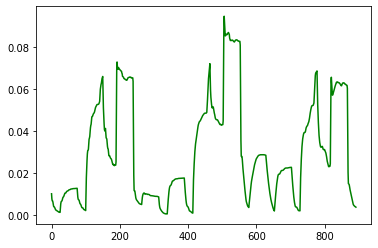

In [4]:
model = CalibNet(pretrained=True, loss=torch.nn.SmoothL1Loss())
norm_losses = train(model, train_dataset, epochs=3)
plt.plot(smooth(norm_losses, 50), color='green')

#print(accuracy(model, train_dataset))


In [63]:
train_dataset = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=8
)
with torch.no_grad():
    for i, batch in enumerate(train_dataset):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        outputs = model.forward(inputs)
        print(str(outputs) + " " + str(labels))

tensor([[0.0129982512, 0.0515154749]], device='cuda:0') tensor([[0.0334606619, 0.0314920503]], device='cuda:0', dtype=torch.float64)
tensor([[0.0122578014, 0.0526080057]], device='cuda:0') tensor([[0.0333200470, 0.0313171982]], device='cuda:0', dtype=torch.float64)
tensor([[0.0133338906, 0.0529919043]], device='cuda:0') tensor([[0.0332638156, 0.0312027987]], device='cuda:0', dtype=torch.float64)
tensor([[0.0101864580, 0.0536242351]], device='cuda:0') tensor([[0.0332800016, 0.0312272549]], device='cuda:0', dtype=torch.float64)
tensor([[0.0076850038, 0.0551650599]], device='cuda:0') tensor([[0.0333341436, 0.0309629938]], device='cuda:0', dtype=torch.float64)
tensor([[0.0128466189, 0.0534397773]], device='cuda:0') tensor([[0.0334152831, 0.0309614190]], device='cuda:0', dtype=torch.float64)
tensor([[0.0105936574, 0.0541758128]], device='cuda:0') tensor([[0.0334465330, 0.0309776790]], device='cuda:0', dtype=torch.float64)
tensor([[0.0139773851, 0.0533694774]], device='cuda:0') tensor([[0.03

KeyboardInterrupt: 